<a href="https://colab.research.google.com/github/rafaellopezgarcia/colab_notebooks/blob/main/ConvNet_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A Convolutional Neural Network

In [8]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from google.colab import drive
from pathlib import Path
from tabulate import tabulate
from torch.utils.data import DataLoader
from torchvision.transforms import functional as TF

In [34]:
drive.mount('/content/drive')
FOLDERNAME = "neural_networks/vanilla_convnet/"
FILENAME = "cifar_net.pth"
PATH = "/content/drive/My Drive/" + FOLDERNAME + FILENAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Save/Load model

In [36]:
def save(model):
  torch.save(model.state_dict(), Path(PATH))

def load(model):
  if os.path.exists(PATH):
    print(f"{PATH} exists")
    model.load_state_dict(torch.load(Path(PATH)))
  else:
    raise FileNotFoundError("Path does not exist")

## Hyperparameters

In [2]:
batch_size = 4
epochs = 9
lr = 1e-3
print_every = 1000

## Dataset

In [35]:
transf = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

mnist_train = torchvision.datasets.CIFAR10('./', download=True, train=True, transform=transf)
mnist_test = torchvision.datasets.CIFAR10('./', download=True, train=False, transform=transf)
labels =['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
mnist_traindl = DataLoader(mnist_train, batch_size)

image_sz = mnist_test[0][0].shape
dataset_props = {'train size': len(mnist_train), 'test size': len(mnist_test), 'image size': image_sz, 'pixels': image_sz[1]*image_sz[2], 'channels': image_sz[0]}
for key, value in dataset_props.items():
  print(f'{key}: {value}')

Files already downloaded and verified
Files already downloaded and verified
train size: 50000
test size: 10000
image size: torch.Size([3, 32, 32])
pixels: 1024
channels: 3


## Visualisation

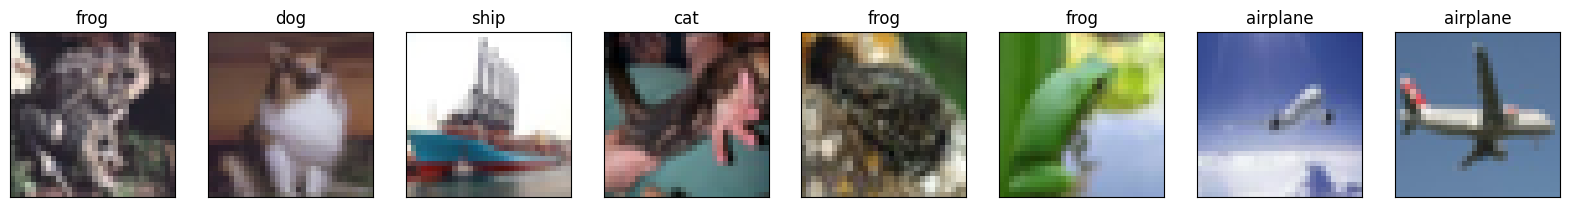

In [4]:
nxmpls = 8
fig, axs = plt.subplots(1, nxmpls, figsize=(20,10))

dataset_ixs = torch.randint(0, len(mnist_test), (nxmpls,))
for ix in range(nxmpls):
  x, y = mnist_test[dataset_ixs[ix]]
  x = x / 2 + 0.5
  img = TF.to_pil_image(x)
  axs[ix].imshow(img)
  axs[ix].set_xticks([])
  axs[ix].set_yticks([])
  axs[ix].set_title(labels[y])


## Evaluation

In [5]:
def accuracy(logits, y):
  pred = torch.argmax(logits, -1)
  print(logits.shape, y.shape)
  return torch.mean((pred==y).to(torch.float))

In [6]:
def per_class_accuracy(logits, y):
  pred = torch.argmax(logits, -1)
  pred_one_hot = F.one_hot(pred, 10)
  y_one_hot = F.one_hot(y, 10)
  tp = pred_one_hot * y_one_hot
  accs = torch.sum(tp, 0) / torch.sum(pred_one_hot, 0)
  print("Per class accuracy values")
  d = [[labels[ix], accs[ix]] for ix in range(len(labels))]
  print(tabulate(d, headers=["Label", "Accuracy"], floatfmt=".2f"))

## Model

In [37]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 10, 6, 2) # in_channels, out_channels, K, S, P
    self.conv2 = nn.Conv2d(10, 8, 4, 1)
    self.conv3 = nn.Conv2d(8, 8, 4, 1)
    self.linear1 = nn.Linear(512, 300)
    self.linear2 = nn.Linear(300, 10)

  def forward(self, x, y=None):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = torch.flatten(x, 1)
    x = F.relu(self.linear1(x))
    x = self.linear2(x)

    if y is None:
      return x
    loss = F.cross_entropy(x, y)
    return x, loss

  def apply_1conv(self, x):
    x = F.relu(self.conv1(x))
    return x

  def apply_2convs(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    return x

  def apply_3convs(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    return x

model = ConvNet()
load(model)

/content/drive/My Drive/neural_networks/vanilla_convnet/cifar_net.pth exists


In [ ]:
def is_valid(W, K, S=1, P=0):
  out = (W - K + 2*P) / S + 1
  return out, out.is_integer()

layers = [[6, 2, 0], [4, 1, 0], [4, 1, 0]]
W = 32
for layer in layers:
  K, S, P = layer
  W, state = is_valid(W, K, S, P)
  print(W, state)
print(W**2*8)

14.0 True
11.0 True
8.0 True
512.0


## Learning

In [13]:
def train(model):
  opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  running_loss = 0.0
  for epoch in range(epochs):
    model.train()
    for ix, (xb, yb) in enumerate(mnist_traindl):
      opt.zero_grad()
      logits, loss = model.forward(xb, yb)
      loss.backward()
      opt.step()
      running_loss += loss.item()
      if ix % print_every == print_every-1:
        print(f'[{epoch + 1}, {ix + 1:5d}] loss: {running_loss / print_every:.3f} {loss}')
        running_loss = 0.0

#train(model)

In [20]:
test_loader = DataLoader(mnist_test, len(mnist_test))
x, y = next(iter(test_loader))
pred =model.forward(x)
acc = accuracy(pred, y)
print(acc)
per_class_accuracy(pred, y)

torch.Size([10000, 10]) torch.Size([10000])
tensor(0.5142)
Per class accuracy values
Label         Accuracy
----------  ----------
airplane          0.67
automobile        0.67
bird              0.48
cat               0.37
deer              0.46
dog               0.51
frog              0.61
horse             0.47
ship              0.52
truck             0.51


## Visualise filters